### Step1: prepare data as pickled dict for ELLA analysis

start with seqfish+ data processed by Bento\
this is the only preprocessing step for the dataset

In [1]:
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import pickle
import timeit

#### Load data

In [2]:
##### merfish preprocessed data by Bento
data = anndata.read_h5ad('input/seqfish+_processed.h5ad')
print(data)

##### expression data is stored in `data.uns["points"]`
points = data.uns['points']
cellList = data.obs_names.tolist()
geneList = data.var_names.tolist()
print('#cells', len(cellList), points.cell.nunique())
print('#genes', len(geneList), points.gene.nunique())

##### cell and nucleus area
cellShape = data.obs['cell_shape']
nucleusShape = data.obs['nucleus_shape']

##### add umi==1
points['umi'] = np.full(len(points), 1)

AnnData object with n_obs × n_vars = 179 × 3726
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'cell_radius', 'nucleus_inner_edge_shape', 'cell_inner_edge_shape', 'nucleus_outer_edge_shape', 'n_detected', 'fraction_detected', 'cell_edge_count', 'cell_edge_fraction', 'cytoplasmic_count', 'cytoplasmic_fraction', 'nuclear_count', 'nuclear_fraction', 'nuclear_edge_count', 'nuclear_edge_fraction', 'none_count', 'none_fraction', 'td_cluster'
    var: 'n_detected', 'fraction_detected', 'cell_edge_count', 'cell_edge_fraction', 'cytoplasmic_count', 'cytoplasmic_fraction', 'nuclear_count', 'nuclear_fraction', 'nuclear_edge_count', 'nuclear_edge_fraction', 'none_count', 'none_fraction', 'td_cluster'
    uns: 'points', 'tensor', 'tensor_labels', 'tensor_loadings'
    layers: 'cell_edge', 'cell_edge_p', 'cell_inner_asymmetry', 'cell_inner_proximity', 'cell_outer_asymmetry', 'cell_outer_proximity', 'cytoplasmic', 'cytoplasmic_p', 'l_half_radius', 'l_max', 'l_max_gradient', 'l_min_gradient', 'l_mon

#### Prepare cell mask, nuclear mask, and cell center

In [3]:
##### for each cell get
# cell center (geometric center of the nucleus area)
# nucleus/cell boundaries
# nucleus/cell mask

start = timeit.default_timer()

cell_mask = {}
nuclear_mask = {}
cell_boundary = {}
nuclear_boundary = {}
nuclear_center = {}
for i in range(len(cellList)):
    
    if i%50 == 0:
        print(i, cellList[i])
    
    # cell boundary
    cs_c0 = cellShape[i][10:-2].split(')', 1)
    cs_c1 = cs_c0[0]
    cs_c2 = cs_c1.split(',')
    cs_c3 = []
    for j in cs_c2:
        cs_c3.append([int(float(x)) for x in j.strip().split(' ')])
    cs_c4 = np.array(cs_c3)
    df = pd.DataFrame({'x': cs_c4[:,0], 'y': cs_c4[:,1]})
    cell_boundary[cellList[i]] = df
    
    # cell mask
    contours = cs_c4
    #img = np.zeros(np.amax(cs_c4, axis=0).astype(int))
    img = np.zeros((2000,2000)) # this need to be optimized!!! right now 2000 is sufficient
    cv2.fillPoly(img, pts =[contours], color=255)
    nz = np.nonzero(img)
    df = pd.DataFrame({'y': nz[0], 'x': nz[1]})
    cell_mask[cellList[i]] = df
    
    # nuclear boundary
    ns_c0 = nucleusShape[i][10:-2].split(')', 1)
    ns_c1 = ns_c0[0]
    ns_c2 = ns_c1.split(',')
    ns_c3 = []
    for j in ns_c2:
        ns_c3.append([int(float(x)) for x in j.strip().split(' ')])
    ns_c4 = np.array(ns_c3)
    df = pd.DataFrame({'x': ns_c4[:,0], 'y': ns_c4[:,1]})
    nuclear_boundary[cellList[i]] = df
    
    # nuclear mask    
    contours = ns_c4
    img = np.zeros((2000,2000))
    cv2.fillPoly(img, pts =[contours], color=255)
    nz = np.nonzero(img)
    df = pd.DataFrame({'y': nz[0], 'x': nz[1]})
    nuclear_mask[cellList[i]] = df   
    
    # nuclear center
    kmeans = KMeans(n_clusters=1, init='k-means++', max_iter=200, n_init=5)
    pred_y = kmeans.fit_predict(ns_c4)
    nuclear_center[cellList[i]] = [round(kmeans.cluster_centers_[0,0]), round(kmeans.cluster_centers_[0,1])]
    
stop = timeit.default_timer()
print('Time: ', stop - start) # ~12s

0 0-0
50 6-3
100 4-8
150 7-13
Time:  12.350476273801178


In [4]:
##### add `cell` column to cell/nuclear mask
cell_mask2 = {}
nuclear_mask2 = {}
for c in cellList:
    cell_c = cell_mask[c]
    nuclear_c = nuclear_mask[c]
    cell_c['cell'] = [c]*len(cell_c)
    nuclear_c['cell'] = [c]*len(nuclear_c)
    cell_mask2[c] = cell_c
    nuclear_mask2[c] = nuclear_c

##### concatenate all cell/nuclear mask2 to one df
cell_mask_df = pd.concat(list(cell_mask2.values()))
nuclear_mask_df = pd.concat(list(nuclear_mask2.values()))

#### Prepare df

In [5]:
##### add nuclear center to df
centerX = np.zeros(len(points), dtype=int)
centerY = np.zeros(len(points), dtype=int)
cell_ = points.cell.copy()

for c in cellList:
    centerX[cell_ == c] = nuclear_center[c][0]
    centerY[cell_ == c] = nuclear_center[c][1]
    
df = points.copy()
df['centerX'] = centerX
df['centerY'] = centerY

##### add type to df
df['type'] = ['fibroblast']*len(df)

##### add sc_total to df
sc_total = np.zeros(len(points), dtype=int)
cell_ = points.cell.copy()

for c in cellList:
    sc_total[cell_ == c] = np.sum(cell_ == c)
    
df['sc_total'] = sc_total

#### Compute average nuclear diameter/cell diameter (nc) ratio
also use this as QC

In [6]:
##### nc ratio of cells in cellList
nc_ratio = []
for c in cellList:
    nb = nuclear_boundary[c]
    cb = cell_boundary[c]
    cc = nuclear_center[c]
    avg_nc_r = np.mean((((nb.x - cc[0])**2 + (nb.y - cc[1])**2)**0.5)/(((cb.x - cc[0])**2 + (cb.y - cc[1])**2)**0.5))
    nc_ratio.append(avg_nc_r)
nc_ratio = np.array(nc_ratio)    

In [7]:
##### mean and sd of nc ratios
nc_ratio_avg = np.mean(nc_ratio)
nc_ratio_sd = np.std(nc_ratio)
print(f'avg nc ratio {nc_ratio_avg:.3f} with sd {nc_ratio_sd:.3f}')

avg nc ratio 0.462 with sd 0.075


171 out of 179 cells left
{'fibroblast': 0.460279450346061}


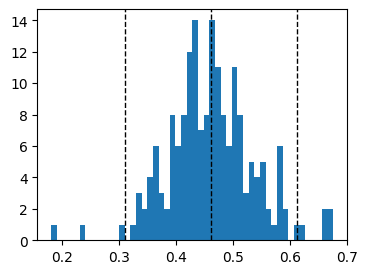

In [9]:
##### filter out outlier cells based on nc ratio

# filter out cells with nc ratio beyond ksd*sd
ksd = 2 # <<<<<

# hist nc ratio
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
n, bins, patches = ax.hist(nc_ratio, 50)
ax.axvline(nc_ratio_avg, color='k', linestyle='dashed', linewidth=1)
ax.axvline(nc_ratio_avg-ksd*nc_ratio_sd, color='k', linestyle='dashed', linewidth=1)
ax.axvline(nc_ratio_avg+ksd*nc_ratio_sd, color='k', linestyle='dashed', linewidth=1)

# filters
cellList_ncfiltered = np.array(cellList)[(nc_ratio>=(nc_ratio_avg-ksd*nc_ratio_sd))&(nc_ratio<=(nc_ratio_avg+ksd*nc_ratio_sd))]
print(f'{len(cellList_ncfiltered)} out of {len(cellList)} cells left')

# filtering
df_ncfiltered = df[df.cell.isin(cellList_ncfiltered)]
cell_mask_df_ncfiltered = cell_mask_df[cell_mask_df.cell.isin(cellList_ncfiltered)]
nuclear_mask_df_ncfiltered = nuclear_mask_df[nuclear_mask_df.cell.isin(cellList_ncfiltered)]

# save the avg nc ratio of remaining cells
nc_ratio_dict = {}
nc_ratio_dict['fibroblast'] = np.mean(np.array(nc_ratio)[(nc_ratio>=(nc_ratio_avg-ksd*nc_ratio_sd))&(nc_ratio<=(nc_ratio_avg+ksd*nc_ratio_sd))])
print(nc_ratio_dict)

#### Gene and cell lists

In [10]:
##### cell type list
type_list = df_ncfiltered.type.unique().tolist()
print(type_list)

['fibroblast']


In [15]:
##### filtering params
# 1. min #cells available for a gene
nc_avl_min = 50 
# 2. >=`nc_expr_thre` number of cells with gene counts>=`expr_thre`
expr_thre = 3
nc_expr_thre = 5
# 3. sort the genes and get the dataframe

In [16]:
# 1. nc_avl_min
gene_list_dict1 = {}
df_dict1 = {}
for t in type_list:
    df_t = df_ncfiltered[df_ncfiltered.type==t]
    nc_avl_t = df_t.groupby('gene')['cell'].nunique()
    nc_avl_t_filtered = nc_avl_t[nc_avl_t>=nc_avl_min]
    gene_list_dict1[t] = nc_avl_t_filtered.index.to_numpy()
    df_dict1[t] = df_t[df_t.gene.isin(gene_list_dict1[t])]
    print(f'type {t} #genes={len(gene_list_dict1[t])}')

type fibroblast #genes=2747


In [17]:
# 2. nc_expr_thre and expr_thre
gene_list_dict2 = {}
for t in type_list:
    df_t = df_dict1[t]
    df_t_gbG = df_t.groupby('gene')
    gl_t = []
    for g in gene_list_dict1[t][:]:
        df_t_g = df_t_gbG.get_group(g)
        sc_umi_g = df_t_g.groupby('cell')['umi'].sum()
        if np.sum(sc_umi_g>=expr_thre)>=nc_expr_thre:
            gl_t.append(g)
    gene_list_dict2[t] = np.array(gl_t)
    print(f'type {t} #genes={len(gl_t)}')

type fibroblast #genes=2747


In [76]:
# 3. get the df and sort the genes
gene_list_dict3 = {}
cell_list_dict3 = {}
df_dict3 = {}
for t in type_list:
    gl_t2 = gene_list_dict2[t].tolist()
    df_t = df_dict1[t]
    df_t3 = df_t[df_t.gene.isin(gl_t2)]
    gl_t3 = df_t3.groupby('gene')['umi'].sum().sort_values(ascending=False).index.to_numpy()
    gene_list_dict3[t] = gl_t3[:len(gl_t2)]
    df_dict3[t] = df_t3
    cell_list_dict3[t] = df_t3.cell.unique().tolist()

In [77]:
data_df = pd.concat(list(df_dict3.values()))
gene_list_dict = gene_list_dict3
cell_list_dict = cell_list_dict3
cell_list_all = [item for sublist in list(cell_list_dict.values()) for item in sublist]

#### Save prepared data

In [78]:
##### save data
outfile = 'output/seqfish_data_dict.pkl'
# save
pickle_dict = {}
pickle_dict['nc_ratio_dict'] = nc_ratio_dict
pickle_dict['type_list'] = type_list
pickle_dict['gene_list_dict'] = gene_list_dict
pickle_dict['cell_list_dict'] = cell_list_dict
pickle_dict['cell_list_all'] = cell_list_all
pickle_dict['cell_mask_df'] = cell_mask_df_ncfiltered
pickle_dict['nuclear_mask_df'] = nuclear_mask_df_ncfiltered
pickle_dict['data_df'] = df_ncfiltered
with open(outfile, 'wb') as f:
    pickle.dump(pickle_dict, f)

# load
# with open(outfile, 'rb') as f:
#     pickle_dict = pickle.load(f)
# nc_ratio_dict = pickle_dict['nc_ratio_dict']
# type_list = pickle_dict['type_list']
# gene_list_dict = pickle_dict['gene_list_dict']
# cell_list_dict = pickle_dict['cell_list_dict']
# cell_list_all = pickle_dict['cell_list_all']
# cell_mask_df = pickle_dict['cell_mask_df']
# nuclear_mask_df = pickle_dict['nuclear_mask_df']
# df = pickle_dict['data_df']
# beta_kernal_param_list = pickle_dict['beta_kernal_param_list']
# ntanbin_dict = pickle_dict['ntanbin_dict']